
BANK QUEUE SIMULATION - COMMERCIAL BANK GELIOYA BRANCH


------------------------------------------------------------------------------------------------------------------------
  SCENARIO: Current Setup (1 Teller, 1 ATM)
------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------
Customer arrival and Service Configuration
------------------------------------------------------------
Customer 1 arrives at 4.25 min
Customer 2 arrives at 7.75 min
Customer 2 finished ATM at 11.29 min (service=3.54)
Customer 3 arrives at 11.61 min
Customer 1 finished Teller at 13.28 min (service=9.03)
Customer 4 arrives at 16.18 min
Customer 3 finished ATM at 18.71 min (service=7.10)
Customer 5 arrives at 20.69 min
Customer 4 finished ATM at 24.65 min (service=5.94)
Customer 6 arrives at 26.20 min
Customer 6 finished ATM at 30.63 min (service=4.43)
Customer 5 finished Teller at 31.16 m

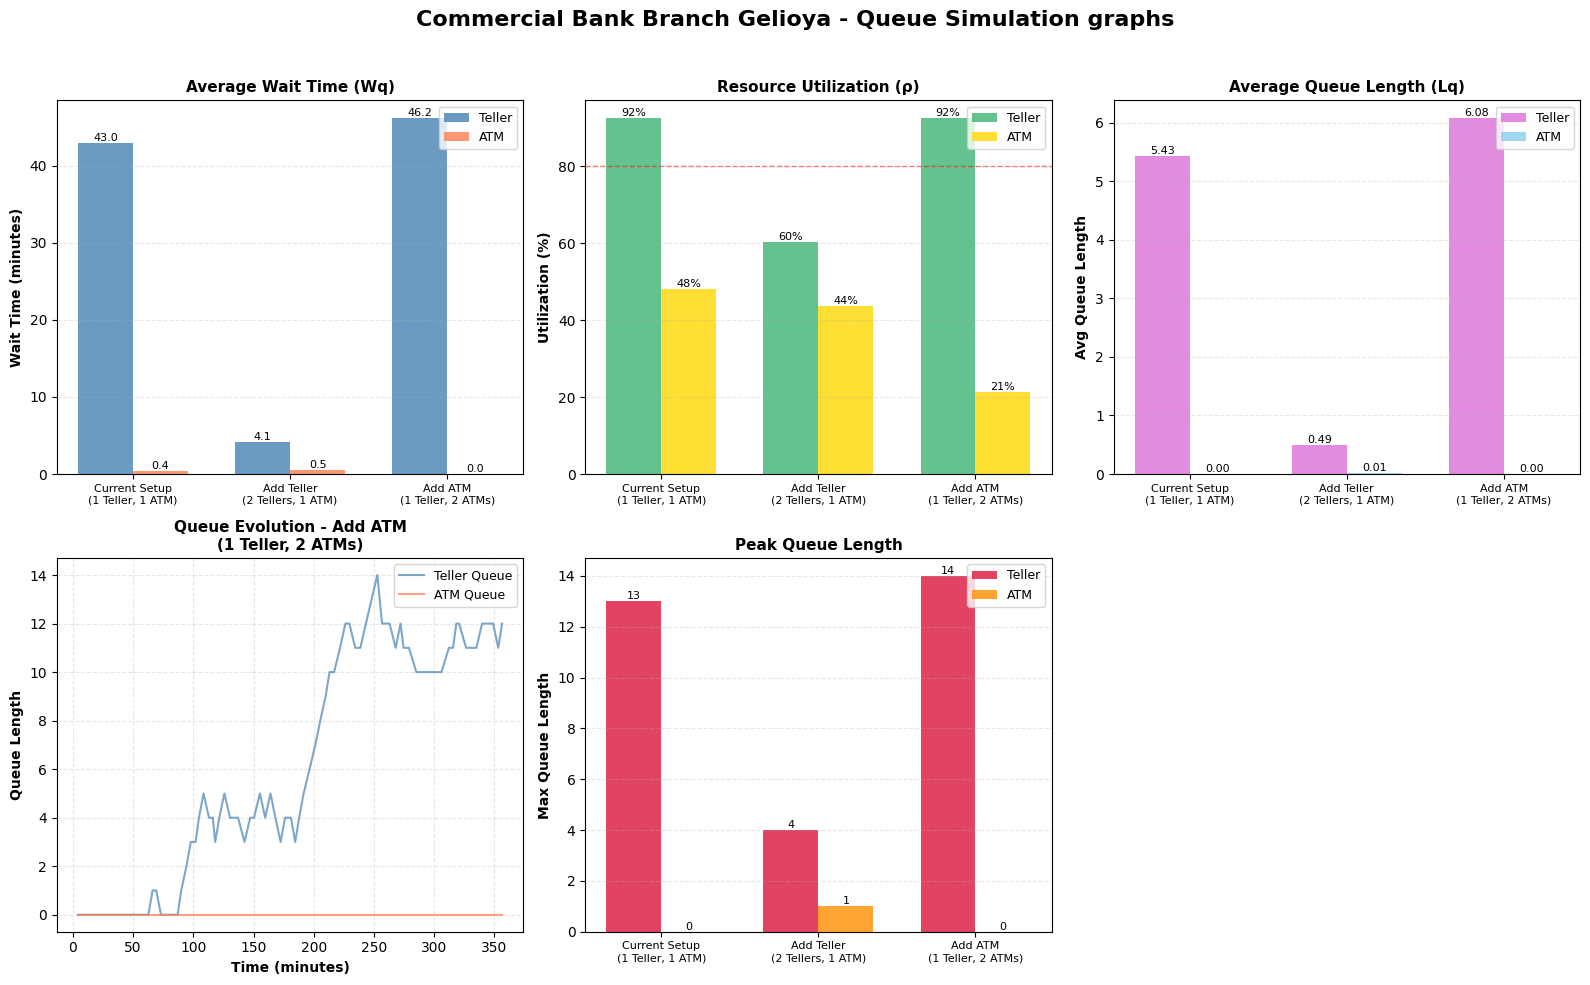



 Simulation and visualization complete!


In [ ]:
"""
Bank Queue Simulation with KPI Analysis
========================================
"""

import simpy
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np


# SIMULATION PARAMETERS

RANDOM_SEED = 42
SIM_TIME = 360                  # Simulation duration (minutes)
INTER_ARRIVAL = 4.0             # Mean time between customer arrivals (minutes)
TELLER_SERVICE_TIME = 8.0       # Mean teller service time (minutes)

# DATA COLLECTION ARRAYS

wait_times_teller = []
wait_times_atm = []
queue_lengths_teller = []
queue_lengths_atm = []
time_points = []

# Utilization tracking
busy_time_teller = 0.0
busy_time_atm = 0.0
customers_served_teller = 0 
customers_served_atm = 0

#---------------------------------------------------------------------------------------
# SIMULATION PROCESSES

def customer(env, name, teller, atm):
    """
    Simulate a single customer's journey through the bank.
    
    Each customer:
    - Arrives at a specific time
    - Chooses between teller (60%) or ATM (40%)
    - Waits in queue if resource is busy
    - Gets served with realistic service time
    - Records wait time and service duration
    
    Parameters:
    env : simpy.Environment =  The simulation environment  
    name : str = Customer identifier  
    teller : simpy.Resource =  Teller service resource
    atm : simpy.Resource =  ATM service resource
    """
    global busy_time_teller, busy_time_atm
    global customers_served_teller, customers_served_atm
    global customer_id  
    
    arrival_time = env.now
    if customer_id <= 10:
        print(f"{name} arrives at {arrival_time:.2f} min")
    elif customer_id == 11:
         print("\nSIMULATION CONTINUES ..... (logging disabled)")
    
    # Decision: ATM (40%) or Teller (60%)
    if random.random() < 0.4:
        
        # ATM Service
        with atm.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times_atm.append(wait)
            
            # Realistic ATM timing components
            operating_time = random.uniform(1.5, 3.5)    # Card, PIN, menu navigation
            transaction_time = random.uniform(1.0, 2.0)  # Actual withdrawal/deposit
            total_service_time = operating_time + transaction_time
            
            # 10% chance of slow user (forgot PIN, checking balance multiple times)
            if random.random() < 0.10:
                total_service_time += random.uniform(1.0, 3.0)
            
            busy_time_atm += total_service_time
            yield env.timeout(total_service_time)
            customers_served_atm += 1
            if customer_id <= 10:
                print(f"{name} finished ATM at {env.now:.2f} min (service={total_service_time:.2f})")
            elif customer_id == 11:
                print("\nSIMULATION CONTINUES ..... (logging disabled)")
    
    else:
        #   Teller Service 
        with teller.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times_teller.append(wait)
            
            # Exponentially distributed service time (standard queueing assumption)
            service_time = random.expovariate(1.0 / TELLER_SERVICE_TIME)
            
            busy_time_teller += service_time
            yield env.timeout(service_time)
            customers_served_teller += 1
            if customer_id <= 10:
                print(f"{name} finished Teller at {env.now:.2f} min (service={service_time:.2f})")
            elif customer_id == 11:    
                print("\nSIMULATION CONTINUES ..... (logging disabled)")

#---------------------------------------------------------------------------------------

def customer_arrivals(env, teller, atm):
    """
    Generate customer arrivals with realistic inter-arrival times.
    
    Uses normal distribution for more realistic spacing compared to pure exponential.
    Tracks queue lengths at each arrival event.
    
    Parameters:
    env : simpy.Environment =  The simulation environment
    teller : simpy.Resource =  Teller service resource
    atm : simpy.Resource =  ATM service resource
    """
    global customer_id
    customer_id = 0

    while True:
        # Normal distribution with standard deviation for variability
        # Ensures minimum 1-minute gap (prevents unrealistic simultaneous arrivals)
        arrival_gap = max(random.normalvariate(INTER_ARRIVAL, 1.0), 1.0)
        yield env.timeout(arrival_gap)
        
        customer_id += 1
        env.process(customer(env, f"Customer {customer_id}", teller, atm))
        
        # Record queue lengths for analysis
        queue_lengths_teller.append(len(teller.queue))
        queue_lengths_atm.append(len(atm.queue))
        time_points.append(env.now)

print("\n" + "="*60)
print("BANK QUEUE SIMULATION - COMMERCIAL BANK GELIOYA BRANCH")
print("="*60)
          

#---------------------------------------------------------------------------------------

# SIMULATION EXECUTION & ANALYSIS

def run_simulation(num_tellers=1, num_atms=1, arrival_rate=INTER_ARRIVAL):
    """
    Execute simulation and compute comprehensive KPIs.
    
    Parameters:
    num_tellers : int =  Number of teller counters
    num_atms : int =  Number of ATM machines
    arrival_rate : float =  Mean inter-arrival time (minutes)
    
    Returns:
    dict
        Comprehensive results including wait times, utilization, queue lengths
    """
    global INTER_ARRIVAL
    global busy_time_teller, busy_time_atm
    global customers_served_teller, customers_served_atm
    global wait_times_teller, wait_times_atm
    global queue_lengths_teller, queue_lengths_atm, time_points
    
    # Reset all data structures
    INTER_ARRIVAL = arrival_rate
    wait_times_teller.clear()
    wait_times_atm.clear()
    queue_lengths_teller.clear()
    queue_lengths_atm.clear()
    time_points.clear()
    busy_time_teller = busy_time_atm = 0.0
    customers_served_teller = customers_served_atm = 0
    
    # Initialize simulation
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    
    # Create resources
    teller = simpy.Resource(env, capacity=num_tellers)
    atm = simpy.Resource(env, capacity=num_atms)

    print("\n" + "-"*60)
    print("Customer arrival and Service Configuration")
    print("-"*60)  

    # Start customer arrival process
    env.process(customer_arrivals(env, teller, atm))
    
    # Run simulation
    env.run(until=SIM_TIME)
    
 #---------------------------------------------------------------------------------------
    # KPI CALCULATIONS
    
    total_customers = customers_served_teller + customers_served_atm
    arrival_rate_lambda = total_customers / SIM_TIME  # customers per minute
    
    # --- TELLER KPIs ---
    avg_wait_teller = statistics.mean(wait_times_teller) if wait_times_teller else 0
    avg_queue_teller = statistics.mean(queue_lengths_teller) if queue_lengths_teller else 0
    max_queue_teller = max(queue_lengths_teller, default=0)
    service_rate_teller = (customers_served_teller / busy_time_teller) if busy_time_teller > 0 else 0
    utilization_teller = busy_time_teller / (SIM_TIME * num_tellers)
    
    # --- ATM KPIs ---
    avg_wait_atm = statistics.mean(wait_times_atm) if wait_times_atm else 0
    avg_queue_atm = statistics.mean(queue_lengths_atm) if queue_lengths_atm else 0
    max_queue_atm = max(queue_lengths_atm, default=0)
    service_rate_atm = (customers_served_atm / busy_time_atm) if busy_time_atm > 0 else 0
    utilization_atm = busy_time_atm / (SIM_TIME * num_atms)

 #---------------------------------------------------------------------------------------
  
    # RESULTS DISPLAY

    print("\n" + "="*60)
    print("SIMULATION RESULTS")
    print("="*60)
    print(f"Total Customers Served: {total_customers}")
    print(f"  - Teller: {customers_served_teller} ({customers_served_teller/total_customers*100:.1f}%)")
    print(f"  - ATM: {customers_served_atm} ({customers_served_atm/total_customers*100:.1f}%)")
    
    print("\n" + "-"*60)
    print("TELLER PERFORMANCE")
    print("-"*60)
    print(f"  Average Wait Time (Wq):      {avg_wait_teller:.2f} minutes")
    print(f"  Average Queue Length (Lq):   {avg_queue_teller:.2f} customers")
    print(f"  Maximum Queue Length:        {max_queue_teller} customers")
    print(f"  Arrival Rate (λ):            {arrival_rate_lambda:.3f} cust/min")
    print(f"  Service Rate (μ):            {service_rate_teller:.3f} cust/min")
    print(f"  Utilization (ρ):             {utilization_teller:.2%}")
    
    print("\n" + "-"*60)
    print("ATM PERFORMANCE")
    print("-"*60)
    print(f"  Average Wait Time (Wq):      {avg_wait_atm:.2f} minutes")
    print(f"  Average Queue Length (Lq):   {avg_queue_atm:.2f} customers")
    print(f"  Maximum Queue Length:        {max_queue_atm} customers")
    print(f"  Arrival Rate (λ):            {arrival_rate_lambda:.3f} cust/min")
    print(f"  Service Rate (μ):            {service_rate_atm:.3f} cust/min")
    print(f"  Utilization (ρ):             {utilization_atm:.2%}")
    
    return {
        "teller_wait": avg_wait_teller,
        "atm_wait": avg_wait_atm,
        "teller_util": utilization_teller,
        "atm_util": utilization_atm,
        "teller_Lq": avg_queue_teller,
        "atm_Lq": avg_queue_atm,
        "teller_max_queue": max_queue_teller,
        "atm_max_queue": max_queue_atm,
        "time": list(time_points),
        "queue_teller": list(queue_lengths_teller),
        "queue_atm": list(queue_lengths_atm)
    }


#---------------------------------------------------------------------------------------

# SCENARIO TESTING

scenarios = {
    "Current Setup\n(1 Teller, 1 ATM)": (1, 1, 4.0),
    "Add Teller\n(2 Tellers, 1 ATM)": (2, 1, 4.0),
    "Add ATM\n(1 Teller, 2 ATMs)": (1, 2, 4.0)
}

results = {}

for scenario_name, (num_tellers, num_atms, arrival_rate) in scenarios.items():
    print("\n\n" + "-"*120)
    print(f"  SCENARIO: {scenario_name.replace(chr(10), ' ')}")
    print("-"*120)
    results[scenario_name] = run_simulation(
        num_tellers=num_tellers,
        num_atms=num_atms,
        arrival_rate=arrival_rate
    )
#---------------------------------------------------------------------------------------

# VISUALIZATION - Queue Simulation graphs

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Commercial Bank Branch Gelioya - Queue Simulation graphs', 
             fontsize=16, fontweight='bold', y=0.98)

scenario_names = list(results.keys())
n_scenarios = len(scenario_names)
x = np.arange(n_scenarios)
width = 0.35

# --- SUBPLOT 1: Wait Times Comparison ---
ax1 = plt.subplot(2, 3, 1)
teller_waits = [results[s]["teller_wait"] for s in scenario_names]
atm_waits = [results[s]["atm_wait"] for s in scenario_names]

bars1 = ax1.bar(x - width/2, teller_waits, width, label='Teller', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, atm_waits, width, label='ATM', color='coral', alpha=0.8)

ax1.set_ylabel('Wait Time (minutes)', fontsize=10, fontweight='bold')
ax1.set_title('Average Wait Time (Wq)', fontsize=11, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(scenario_names, fontsize=8)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

# --- SUBPLOT 2: Utilization ---
ax2 = plt.subplot(2, 3, 2)
teller_utils = [results[s]["teller_util"]*100 for s in scenario_names]
atm_utils = [results[s]["atm_util"]*100 for s in scenario_names]

bars3 = ax2.bar(x - width/2, teller_utils, width, label='Teller', color='mediumseagreen', alpha=0.8)
bars4 = ax2.bar(x + width/2, atm_utils, width, label='ATM', color='gold', alpha=0.8)

ax2.set_ylabel('Utilization (%)', fontsize=10, fontweight='bold')
ax2.set_title('Resource Utilization (ρ)', fontsize=11, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(scenario_names, fontsize=8)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axhline(y=80, color='red', linestyle='--', linewidth=1, alpha=0.5, label='80% threshold')

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}%', ha='center', va='bottom', fontsize=8)

# --- SUBPLOT 3: Average Queue Length ---
ax3 = plt.subplot(2, 3, 3)
teller_Lq = [results[s]["teller_Lq"] for s in scenario_names]
atm_Lq = [results[s]["atm_Lq"] for s in scenario_names]

bars5 = ax3.bar(x - width/2, teller_Lq, width, label='Teller', color='orchid', alpha=0.8)
bars6 = ax3.bar(x + width/2, atm_Lq, width, label='ATM', color='skyblue', alpha=0.8)

ax3.set_ylabel('Avg Queue Length', fontsize=10, fontweight='bold')
ax3.set_title('Average Queue Length (Lq)', fontsize=11, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(scenario_names, fontsize=8)
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars5, bars6]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# --- SUBPLOT 4: Queue Length Over Time (Last Scenario) ---
ax4 = plt.subplot(2, 3, 4)
last_scenario = scenario_names[-1]
time_data = results[last_scenario]["time"]
queue_teller_data = results[last_scenario]["queue_teller"]
queue_atm_data = results[last_scenario]["queue_atm"]

ax4.plot(time_data, queue_teller_data, color='steelblue', linewidth=1.5, label='Teller Queue', alpha=0.7)
ax4.plot(time_data, queue_atm_data, color='coral', linewidth=1.5, label='ATM Queue', alpha=0.7)
ax4.set_xlabel('Time (minutes)', fontsize=10, fontweight='bold')
ax4.set_ylabel('Queue Length', fontsize=10, fontweight='bold')
ax4.set_title(f'Queue Evolution - {last_scenario}', fontsize=11, fontweight='bold')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3, linestyle='--')

# --- SUBPLOT 5: Maximum Queue Length ---
ax5 = plt.subplot(2, 3, 5)
teller_max = [results[s]["teller_max_queue"] for s in scenario_names]
atm_max = [results[s]["atm_max_queue"] for s in scenario_names]

bars7 = ax5.bar(x - width/2, teller_max, width, label='Teller', color='crimson', alpha=0.8)
bars8 = ax5.bar(x + width/2, atm_max, width, label='ATM', color='darkorange', alpha=0.8)

ax5.set_ylabel('Max Queue Length', fontsize=10, fontweight='bold')
ax5.set_title('Peak Queue Length', fontsize=11, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(scenario_names, fontsize=8)
ax5.legend(loc='upper right', fontsize=9)
ax5.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars7, bars8]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


print("\n\n Simulation and visualization complete!")